In [4]:
# from datetime import datetime
from IPython.display import display, Markdown
from datetime import datetime, date

todays_date = str(datetime.now().date())

display(Markdown(f'# 1. Notebook - VDJ OVA Data exploration, preprocessing & embedding'))
display(Markdown(f'Author: Lena Erlach'))
display(Markdown(f'Created: 2023-08-24'))
# display(Markdown(f'Last modified: {todays_date}'))

# 1. Notebook - VDJ OVA Data exploration, preprocessing & embedding

Author: Lena Erlach

Created: 2023-08-24

In [1]:
import numpy as np
import pandas as pd
import abmap
import torch
import matplotlib.pyplot as plt
import os

In [2]:
#### Functions used 

def filter_intersection(datasets: list, seq_col: str, seq_complete_col: str = "seq_complete_HC", verbose: bool = False):
    '''
    Args: 
        datasets: list of len 2
            list of the 2 pandas dfs that should be filtered
        seq_col: str
            column name of sequences, which should be the basis of filtering
        seq_complete_col: str
            column name of with bool values, if sequence is complete
        verbose: bool, default = False
    Returns: 
        datasets_filt1, datasets_filt2: 2 pandas dataframes
            Returns the 2 filtered pandas dfs
    '''
    
    # filter sequences that are not complete
    datasets[0] = datasets[0][datasets[0][seq_complete_col] == True]
    datasets[1] = datasets[1][datasets[1][seq_complete_col] == True]
    
    # get intersection per sample
    intersect_m1 = np.intersect1d(datasets[0][seq_col], datasets[1][seq_col])
    
    # print out number of sequences intersecting
    if verbose is True: print("number of intersecting sequences:", len(intersect_m1))
    
    # filter overlapping sequences per mouse (s1&s2) and (s3&s4)! 
    datasets_filt = []
    
    for i in range(len(datasets)):
        d_filt = datasets[i][~np.isin(datasets[i][seq_col], intersect_m1)]
        datasets_filt.append(d_filt)    
    
    return(datasets_filt[0], datasets_filt[1])
    

    
def preprocess_raw(df, seq_col_HC, seq_col_LC, HC_prefix='VDJ_aa', LC_prefix='VJ_aa', 
                   HC_colsuffix = 'HC', LC_colsuffix='LC'):
    '''
    Args: 
        df: pandas dataframe
            Raw pandas dataframe with the sequences in column 'seq_col'
        seq_col: str
            column name of sequences, which should be the basis of filtering
        HC_prefix, LC_prefix: str
            Prefix of the column names that are included when checking for nan values; e.g. 'VDJ_aa' for HCs, or 'VJ_aa'for LCs
        HC_colsuffix, LC_colsuffix: str
            suffix for the column added to the dataframe, True when nan values existent in checked columsn;

    Returns: 
        df: pandas dataframes
            Returns the filtered pandas dataframes
    '''

    # add a column based on HC complete or LC complete
    col_H = [s for s in df.columns.tolist() if HC_prefix in s]
    col_L = [s for s in df.columns.tolist() if LC_prefix in s]
    df["seq_complete_"+HC_colsuffix] = df[col_H].notna().all(axis=1)
    df["seq_complete_"+LC_colsuffix] = df[col_L].notna().all(axis=1)
    
    
    # filter stop codons '*' from sequences 
    df = df[~df[seq_col].str.contains(r'\*', na=False)]


    # strip last under score from VDJ & VJ sequence
    df[seq_col_HC] = df[seq_col_HC].str.strip('_')
    df[seq_col_LC] = df[seq_col_LC].str.strip('_')

    # reset index
    df.reset_index(drop=True, inplace=True)
    
    
    return(df)



# save fasta files of sequences
# Function adapted from the LModeling_OVA repo 
def save_fasta_file(sequence_df, col_name = "VDJ_aaSeq", id_name = "barcode", n_seq = 500, 
                    subdirectory = "data/", file_prefix = "Seq"):
    """
    Function that writes fasta files from a protein sequences pd.DataFrame; number of sequences per file can be set (in case for the Language
    model embeddings) that will be set to how many sequences can be embedded in one job; 
    
    Note: 
    Sequences won't be filtered, processed or trimmed;
        Args:
            sequence_df (pd.DataFrame): dataframe that contains the sequences in the col_name column and sequence fasta ids in id_name column;

            col_name (string): the name of the dataframe column that stores the protein sequences;

            id_name (string): the name of the dataframe column that stores the sequence ids that are to be used as identifier in the fasta file;

            n_seq (int): number of sequeces to be written per fasta file; (depends on how many can be embedded in one ESM embedding job)

            subdirectory (string): path leading to the folder where fasta files should be stored;

            file_prefix (string): file prefix for the fasta file names;

        """
    import math
    n_start = 0
    num_rounds = math.ceil(len(sequence_df.loc[sequence_df.seq_complete == True, col_name]) / n_seq)

    for r in range(num_rounds):
        print(f'Save fasta: {r}')
        if r < num_rounds - 1:
            # Downlsample OVA sequences
            OVA_VDJs = sequence_df[id_name].tolist()[n_start:n_start + n_seq]
            barcodes = sequence_df[id_name].tolist()[n_start:n_start + n_seq]
            n_start += n_seq
            # save fasta files
            ofile = open(os.path.join(subdirectory, file_prefix + "fasta_" + str(r) + ".txt"), "w")
            for i, bc in enumerate(barcodes):
                ofile.write(">" + bc + "\n" + OVA_VDJs[i] + "\n")
            ofile.close()
            print("file saved:" + str(r))

        elif r == num_rounds - 1:
            OVA_VDJs = sequence_df[col_name].tolist()[n_start:]
            barcodes = sequence_df[id_name].tolist()[n_start:]
            # print("last round")
            # save fasta files
            ofile = open(os.path.join(subdirectory, file_prefix + "fasta_" + str(r) + ".txt"), "w")
            for i, bc in enumerate(barcodes):
                # print(">" + bc)
                ofile.write(">" + bc + "\n" + OVA_VDJs[i] + "\n")
            ofile.close()
            print("last file saved")


In [16]:
# define the specifics for the filtering
seq_col = "VDJ_aaSeq"
seq_col_LC = "VJ_aaSeq" # column name of the sequence to filter for (VDJ_VJ_aaSeq, VDJ_aaSeq, 
seq_complete_col = "seq_complete_HC" # column name of sequence is complete or not (seq_complete, seq_complete_HC, seq_complete_ls) 
sample_names = ["s1", "s2", "s3", "s4"]    # entries in the sample column 
verbose = True


inputFile_raw = "../../data/raw/VDJ_seqs_OVA_mixcrAligned_allCells.csv"

# just save file again, if updated! Most up to date file is done on 28.09.2023 --> LC underscore trimmed now, as well!
outputPath_processed = "../../data/processed/processed_OVA_"+ seq_col +"_df_"+ str(date.today()) +".csv"

# fasta file path 
outputPath_processed_fasta = "../../data/processed/fasta"

In [17]:
# load dataset
OVA_seq_raw = pd.read_csv(inputFile_raw, index_col=0)
print(f'Number of specific: {len(OVA_seq_raw[OVA_seq_raw.group_id == 1])} and nonspecific sequences: {len(OVA_seq_raw[OVA_seq_raw.group_id == 2])}')


OVA_seq_raw = preprocess_raw(OVA_seq_raw, seq_col, seq_col_LC, HC_prefix='VDJ_aa', LC_prefix='VJ_aa', 
                             HC_colsuffix = 'HC', LC_colsuffix='LC')



Number of specific: 823 and nonspecific sequences: 7403
After filtering: 
Number of specific: 823 and nonspecific sequences: 7401


/tmp/ipykernel_37182/476931900.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[seq_col_HC] = df[seq_col_HC].str.strip('_')
/tmp/ipykernel_37182/476931900.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[seq_col_LC] = df[seq_col_LC].str.strip('_')


In [21]:
# split unfiltered dataset by samples and drop duplicated sequencs per sample
s1_VDJ_VJs_uf = OVA_seq_raw[OVA_seq_raw.sample_id == sample_names[0]].drop_duplicates(subset=seq_col)
s2_VDJ_VJs_uf = OVA_seq_raw[OVA_seq_raw.sample_id == sample_names[1]].drop_duplicates(subset=seq_col)
s3_VDJ_VJs_uf = OVA_seq_raw[OVA_seq_raw.sample_id == sample_names[2]].drop_duplicates(subset=seq_col)
s4_VDJ_VJs_uf = OVA_seq_raw[OVA_seq_raw.sample_id == sample_names[3]].drop_duplicates(subset=seq_col)


# Filter sequences that are in the intersection within the mice      
s1_VDJ_VJs, s2_VDJ_VJs = filter_intersection([s1_VDJ_VJs_uf, s2_VDJ_VJs_uf], seq_col, seq_complete_col, verbose=False)
s3_VDJ_VJs, s4_VDJ_VJs = filter_intersection([s3_VDJ_VJs_uf, s4_VDJ_VJs_uf], seq_col, seq_complete_col, verbose=False)


# combine to one dataframe!
seq_df = pd.concat([s1_VDJ_VJs, s2_VDJ_VJs, s3_VDJ_VJs, s4_VDJ_VJs])


# drop duplicates in case sequences overlap in across mice (but then dropping them
# is fine because they show up in the same sample, specific or not specific)
seq_df = seq_df.drop_duplicates(subset=[seq_col]).reset_index(drop=True)

# add column Seq_id column 
seq_df['seq_id'] = [str(x)+'_'+str(seq_df['sample_id'][x]) for x in seq_df.index]

if verbose is True:
    print("\nNumber of unique, non-overlapping " + seq_col + " sequences")
    print("Total:", len(seq_df))
    print("s1:", len(seq_df[seq_df["sample_id"] == "s1"]))
    print("s2:", len(seq_df[seq_df["sample_id"] == "s2"]))
    print("s3:", len(seq_df[seq_df["sample_id"] == "s3"]))
    print("s4:", len(seq_df[seq_df["sample_id"] == "s4"]))


seq_df_comp = seq_df[seq_df.seq_complete == True]
if verbose is True:
    print("\nNumber of unique, non-overlapping " + "VH_VL" + " sequences")
    print("Total:", len(seq_df_comp))
    print("s1:", len(seq_df_comp[seq_df_comp["sample_id"] == "s1"]))
    print("s2:", len(seq_df_comp[seq_df_comp["sample_id"] == "s2"]))
    print("s3:", len(seq_df_comp[seq_df_comp["sample_id"] == "s3"]))
    print("s4:", len(seq_df_comp[seq_df_comp["sample_id"] == "s4"]))


Number of unique, non-overlapping VDJ_aaSeq sequences
Total: 3807
s1: 425
s2: 1661
s3: 149
s4: 1572

Number of unique, non-overlapping VH_VL sequences
Total: 3622
s1: 405
s2: 1590
s3: 145
s4: 1482


### Plot CDR3 length for a check

Text(0.5, 1.0, 'Histogram of CDRH3 Length with Color by group_id')

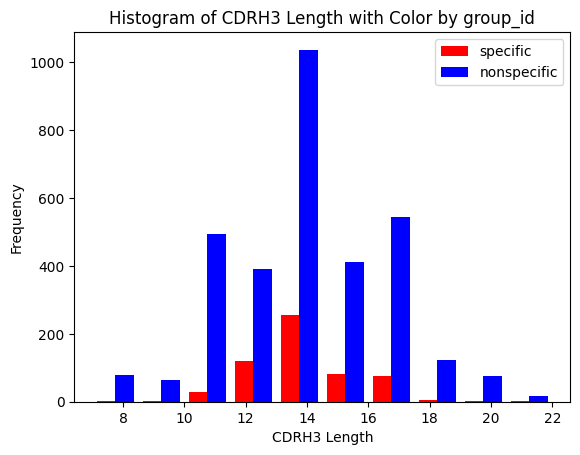

In [8]:
# Create a histogram plot of CDR lengths
# Calculate the lengths of strings in column1
seq_df["CDRH3_length"] = seq_df["VDJ_aaSeqCDR3"].str.len()## seq_df["VDJ_aaSeqCDR3"].apply(len)

# Create a histogram with colored bars
plt.hist([seq_df.CDRH3_length[seq_df.group_id == 1], seq_df.CDRH3_length[seq_df.group_id == 2]], bins=10, 
         label = ["specific","nonspecific"], color= ["red", "blue"])

# Add legend
plt.legend()

# Add labels and title
plt.xlabel("CDRH3 Length")
plt.ylabel("Frequency")
plt.title("Histogram of CDRH3 Length with Color by group_id")

### Save dataframe and fasta files

In [9]:
# Save sequences as fasta file
if not os.path.exists(outputPath_processed_fasta):
    os.makedirs(outputPath_processed_fasta)
    
save_fasta_file(seq_df, col_name = "VDJ_aaSeq", id_name = 'seq_id', n_seq = len(seq_df['seq_id']), 
                subdirectory = outputPath_processed_fasta, file_prefix = "OVA_VDJ_aaSeq")

Save fasta: 0
last file saved


In [88]:
# save preprocessed dataframe
seq_df.to_csv(outputPath_processed, index=False)